## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *

c:\Users\nerea\anaconda3\envs\sinthlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

## Load the data

In [5]:
data_dir = "C:/Users/nerea/OneDrive/Documentos/EPFL_MASTER/PDM/Project/Code/Data"
fname = os.path.join(data_dir, "Sansa_20180507.mat")

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data')

array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_sent_pull could not be converted to int.
field idx_bad could not be converted to int.
field idx_decode_reach could not be converted to int.
field idx_sent_reach could not be converted to int.


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (9222, 64)
removed:   (4611, 60)


c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
c:\Users\nerea\OneDrive\Documentos\EPFL_MASTER\PDM\Project\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 60 + 64 = 124 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

In [14]:
print("all trials:", td.shape[0])

#td = select_trials(td, "result == 'R'") --> previously this, not sure if the new "results" column is actually the "file quality"

td = select_trials(td, "file_quality == 0")

print("successful trials:", td.shape[0])

all trials: 11
successful trials: 10


In [15]:
td.head(3)

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,angles,pressure,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,"[[131.3609671373651, 62.778435057557694, 129.9...","[-1.1113413890635988, -1.1154173470554491, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[[0.89774776, 6.201795, 22.478214, 6.412494, 5...","[[11.223358, 0.6093754, 11.223935, 17.326077, ..."
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,"[[129.73603167442403, 54.73211262243076, 120.8...","[-1.1155262707048532, -1.1184089790756042, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[[0.6667771, 0.0031754556, 13.162496, 3.020980...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0..."
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 1100.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,221,...,"[[127.93534095293505, 66.20842578050232, 128.3...","[-1.1130662785607814, -1.1157941240747453, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206...","[[0.0, 0.059919834, 2.1389797, 19.27935, 48.34...","[[0.0, 17.063677, 0.0, 0.0, 14.686952, 6.16206..."


FROM HERE WORK ON DIVIDING TRIALS BY THE DIFFERENT REACHES AND COMBINING ALL TO FEED DECODERS


In [16]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)

In [17]:
td['idx_start_test'] = td.idx_reach.apply(lambda x: x[0]).astype('int64')

In [18]:
td['idx_end_test'] = td.idx_end_complete.apply(lambda x: x[0]).astype('int64')

### From here testing to create tydy data and only extract windows for the reaches in each trial

In [19]:
group_filt = group_df.loc[group_df.Quality == 0].reset_index()

In [20]:
td_all = pd.concat([td,group_filt.drop(columns = 'type')], axis = 1)

In [21]:
td_filt = td_all[['index', 'num', 'type', 'KUKAPos',
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates']]


In [22]:
td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()

In [23]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

In [24]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

In [25]:
td_filt

,level_0,index,num,type,KUKAPos,idx_kuka_go,idx_reach,idx_end_complete,bad_indices,x,y,z,angles,both_spikes,both_rates,test_start,test_end
0,0,0,4,BASELINE,"[3, 1, 2, 3, 1, 2]","[538, 649, 1201, 1265, 1768, 1834, 2485, 2678,...","[596, 1220, 1789, 2633, 3472]","[661, 1276, 1840, 2689, 3533]","[0, 0, 0, 0, 0]","[[-78.58536911010742, -67.11265182495117, -94....","[[157.52950286865234, 127.36316299438477, 138....","[[239.4000244140625, 213.4429702758789, 217.84...","[[131.3609671373651, 62.778435057557694, 129.9...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...",596,661
1,6,7,11,BASELINE,"[3, 1]","[536, 603, 1113, 1180]","[558, 1134]","[614, 1199]","[0, 0]","[[-71.22147750854492, 0.0, -91.54058074951172,...","[[152.43891143798828, 0.0, 138.395751953125, 1...","[[240.19979095458984, 0.0, 216.5549774169922, ...","[[133.74996637361792, 73.43466569581173, 128.2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.20599091, 0.0, 0.0, 7.9226025e-05, 0....",558,614


In [26]:
win_df = split_time_fields(td_filt, start_margin = 10, end_margin = 10)

`Note`angle 3 is better to visualize X data and angle 4 for Y data.

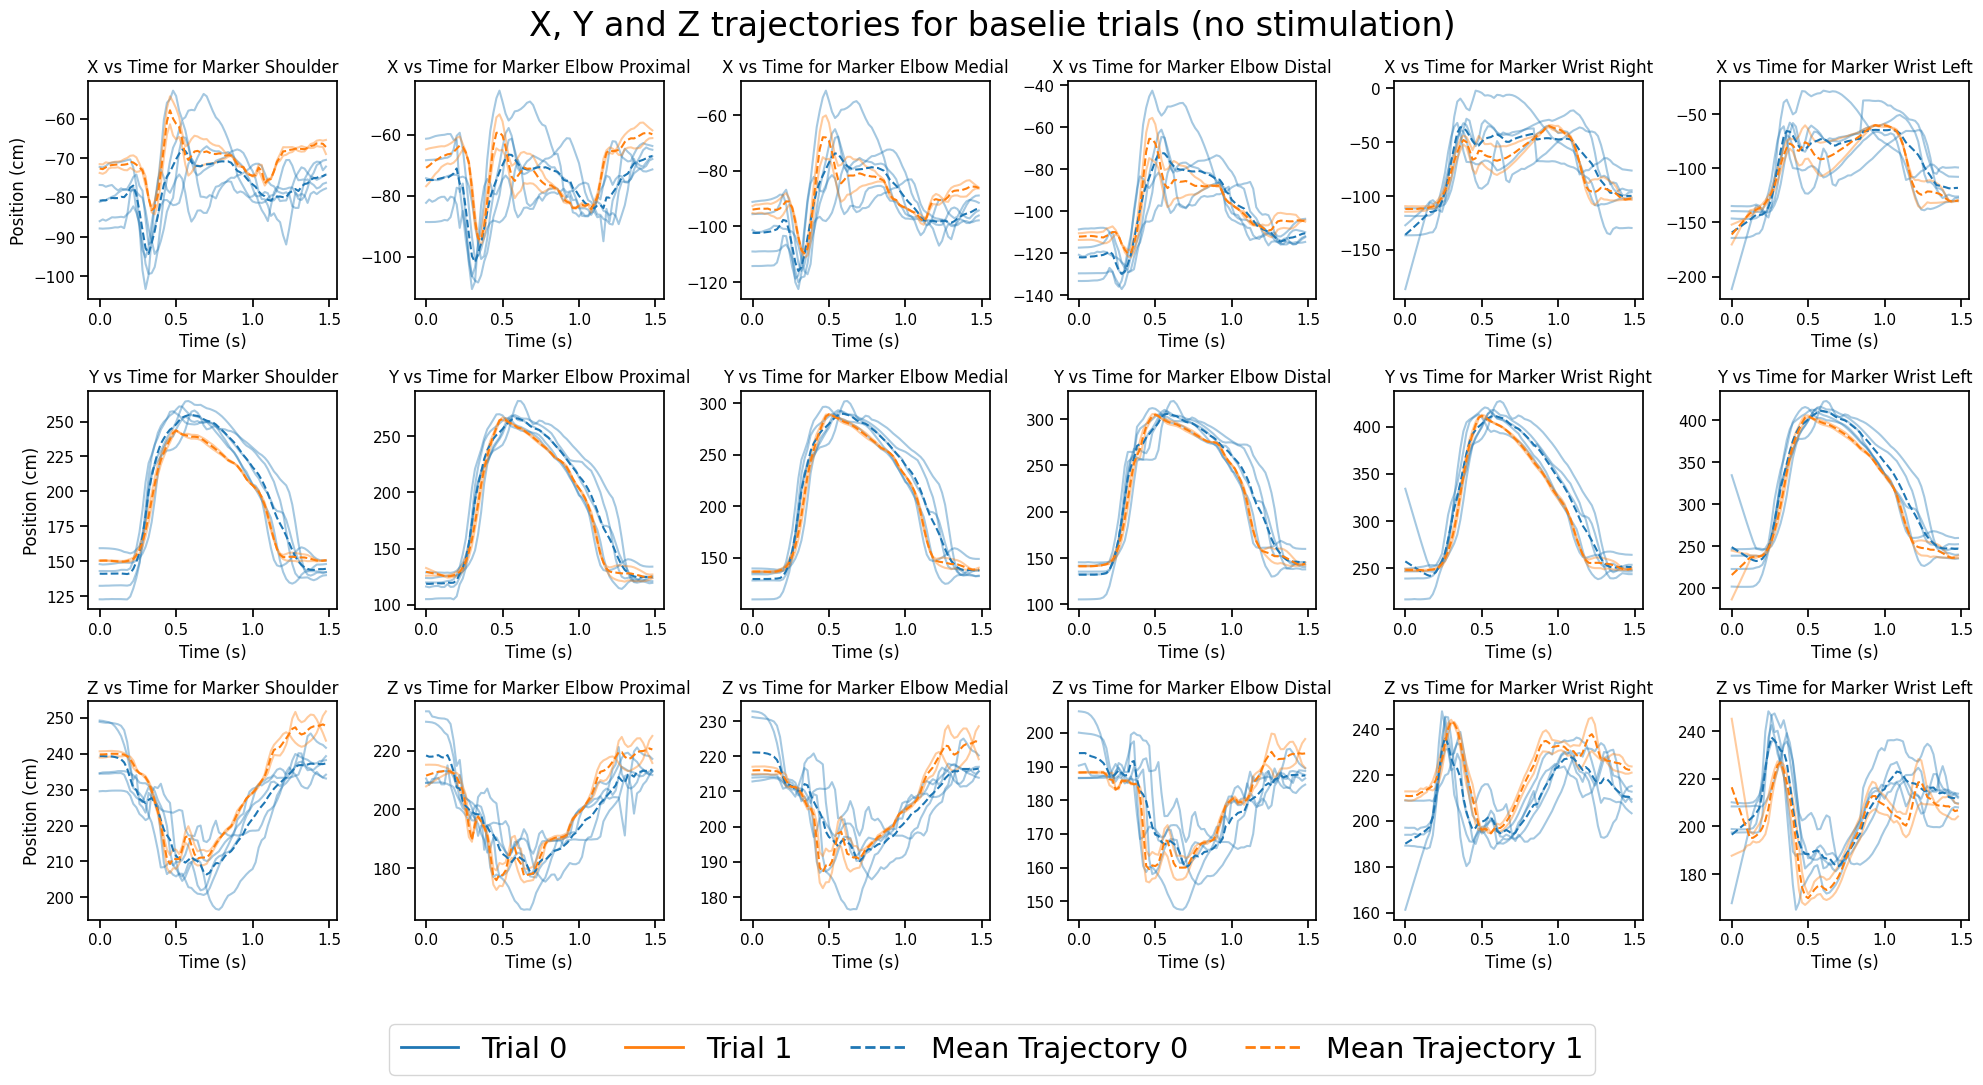

In [27]:
# Visualize the trajectories, split by reach trial
visualize_traj(win_df, ['x', 'y', 'z'], marker_names = ['Shoulder',	'Elbow Proximal',	'Elbow Medial',	'Elbow Distal',	'Wrist Right',	'Wrist Left'])  # Replace df with your actual DataFrame containing trajectory data


In [28]:
win_df['angles'] = np.nan_to_num(win_df['angles'], nan = 0)

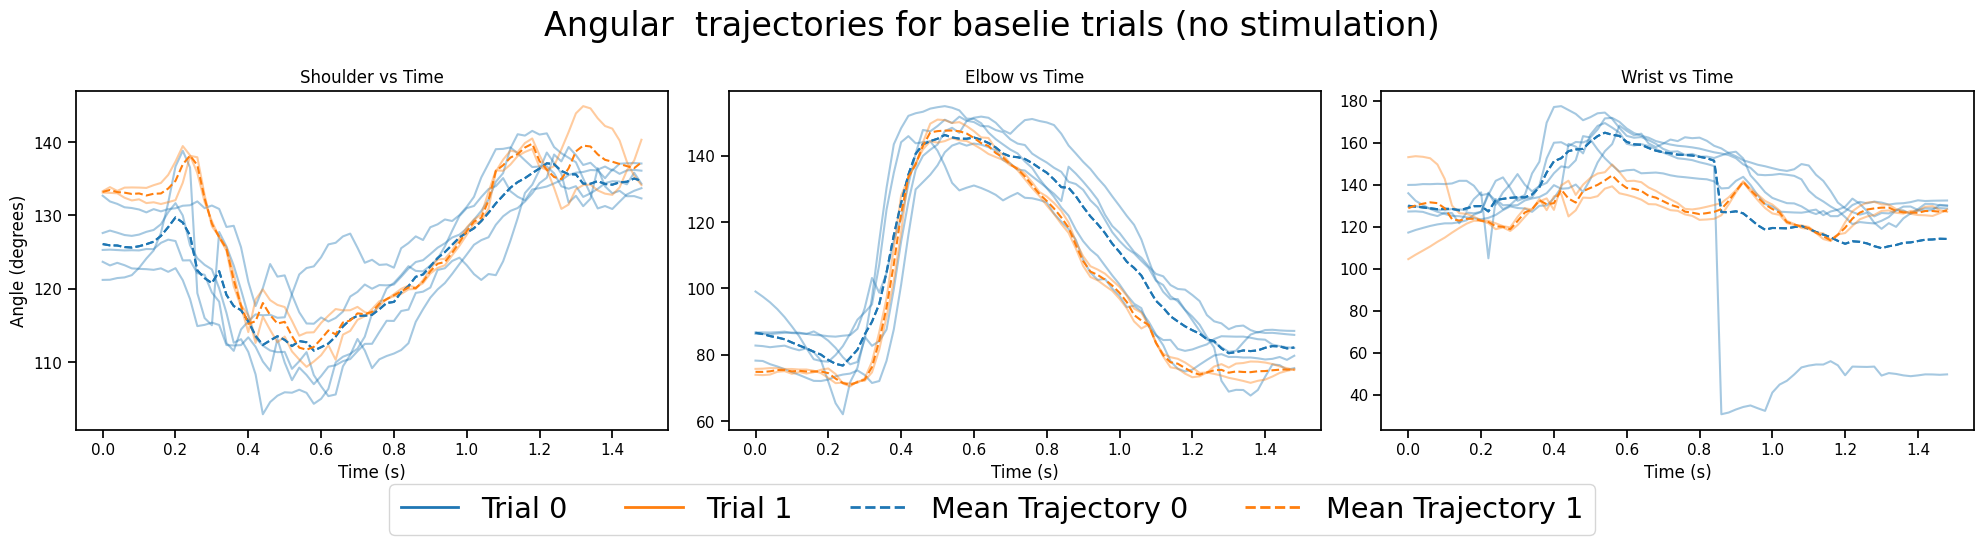

In [29]:
visualize_angles(win_df, 'angles',  angle_names = ['Shoulder', 'Elbow', 'Wrist'])

In [30]:
tidy_df = build_tidy_df(td_filt)

In [31]:
tidy_df.head()

,num,type,KUKAPos,trial_num,reach_num,time_sample,x,y,z,angles,both_spikes,both_rates
0,4,BASELINE,3,0,0,0,"[-76.82929229736328, -68.426025390625, -95.586...","[159.27915954589844, 128.75106811523438, 139.6...","[249.21817779541016, 229.86823272705078, 232.7...","[121.1952173017443, 82.74875424921638, 139.923...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[3.4144492, 0.05999906, 8.377834, 8.377834, 21..."
1,4,BASELINE,3,0,0,1,"[-76.86972045898438, -68.33177947998047, -95.5...","[159.28443145751953, 128.73135375976562, 139.6...","[249.1200408935547, 229.7778091430664, 232.701...","[121.21705491548721, 82.5763971629539, 139.984...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1.5566082, 0.059919834, 5.9934187, 5.9934187,..."
2,4,BASELINE,3,0,0,2,"[-77.28303146362305, -68.28084564208984, -95.5...","[159.21544647216797, 128.71161651611328, 139.6...","[248.9241943359375, 229.64058685302734, 232.54...","[121.44614334667085, 82.244124999752, 140.3289...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.6124499, 0.16098572, 5.5759926, 5.5759926, ..."
3,4,BASELINE,3,0,0,3,"[-77.0178451538086, -68.19149398803711, -95.48...","[159.11837768554688, 128.65155029296875, 139.5...","[248.76033782958984, 229.29763793945312, 232.2...","[121.53587482935515, 82.49683548143778, 140.29...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20780613, 0.44838968, 6.449531, 6.449531, 2..."
4,4,BASELINE,3,0,0,4,"[-76.83100891113281, -68.11762237548828, -95.4...","[158.92301177978516, 128.64197540283203, 139.4...","[248.3923568725586, 228.58123779296875, 231.64...","[121.84607441161177, 82.71495524227275, 140.44...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.063863575, 1.0798991, 7.5875793, 7.5875793,..."


#### **Further preprocess by subtracting cross-condition mean**

In [32]:
# aka center per time point
move_td = subtract_cross_condition_mean(tidy_df) # --> maybe not needed here, I'll still standardize data later

In [33]:
tidy_df['id'] = tidy_df['trial_num'].astype(str) + '_' + tidy_df['reach_num'].astype(str)

We now want to split this data into training-validation-test by doing:

- split by reach_number 
- maximum amount of trial numbers represented in the validation/test data 
- homogeneous distribution of the KUKAPos is possible (changes the trajectory, so that the model does not learn only 1 specific trajectory) 
- Here the type is always BASELINE, as it is the first model, then we will decide if we train also using BC-PULL data or we only test on that.

Now the next question is "What do we want to predict exactly?"

Options:

- Predict only x or y vector with all markers.
- Predict a vector combining all markers for all directions.
- Create an additional variable, combining all the previous information.
- Predict the angles instead of the marker positions.


For the first model let's say we use only "both_rates" as X matrix and "x" position (including all markers) as target (or y). 

In [34]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(tidy_df, target_variable = 'y', num_folds = 5)

fold 0  train_ids  ['0_1', '0_3', '0_4', '0_2', '1_1']
fold 0  val_ids  ['0_0']
fold 0  test_ids  ['1_0']
fold 1  train_ids  ['0_2', '1_0', '0_4', '1_1', '0_1']
fold 1  val_ids  ['0_0']
fold 1  test_ids  ['0_3']
fold 2  train_ids  ['1_1', '0_4', '0_1', '1_0', '0_0']
fold 2  val_ids  ['0_3']
fold 2  test_ids  ['0_2']
fold 3  train_ids  ['0_1', '0_3', '1_1', '1_0', '0_2']
fold 3  val_ids  ['0_4']
fold 3  test_ids  ['0_0']
fold 4  train_ids  ['0_0', '1_0', '0_4', '0_3', '0_1']
fold 4  val_ids  ['1_1']
fold 4  test_ids  ['0_2']


## Ridge Regression

In [35]:
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA, FactorAnalysis

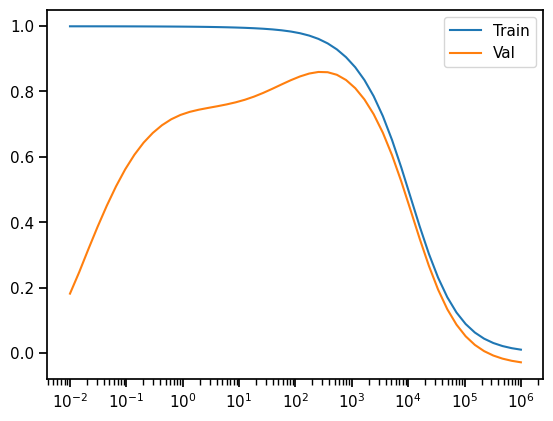

In [36]:
num_folds = 5
dim_reduce = False
num_dim = 10

alphas = np.logspace(-2, 6, 50)

test_score = []
train_score = []
best_a = []

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None

    for a in alphas:
        if dim_reduce == True:

            PCA_model = PCA(num_dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])
        else:
            X_train_ = X_train['fold'+str(i)]
            X_val_ = X_val['fold'+str(i)]
            X_test_ = X_test['fold'+str(i)]

        model = Ridge(alpha = a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
    if i == 0:
        plt.plot(alphas, train_score_a, label = 'Train')
        plt.plot(alphas, val_score_a, label = 'Val')
        plt.xscale('log')
        plt.legend()

    best_a.append(alphas[np.argmax(val_score_a)])
    test_score.append(best_model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(best_model.score(X_train_, y_train['fold'+str(i)]))


In [37]:
best_a

[255.95479226995332,
 120.67926406393289,
 56.89866029018293,
 12.648552168552959,
 82.86427728546842]

In [38]:
train_score

[0.9603516973861058,
 0.9816492491275953,
 0.9909985101640699,
 0.9950846884688639,
 0.9874912084159763]

In [39]:
test_score

[0.8959595674037244,
 0.7747702408500564,
 0.7456712105505098,
 0.6594227666244564,
 0.7454561671153955]

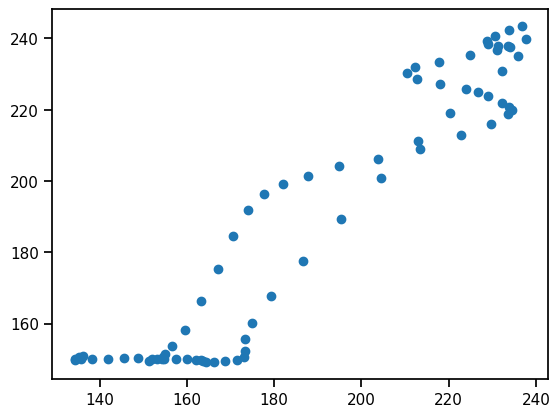

In [40]:
from itertools import product

num_folds = 5
dim_reduce = True
num_dim = 10

alphas = np.logspace(-3, 3, 20)
pca_dimensions = np.arange(5,100,20)  # Define the PCA dimensions to search over

test_score = []
train_score = []
best_a_list = []
best_dim_list = []

# Define the grid of parameters to search over
param_grid = list(product(alphas, pca_dimensions))

for i in range(num_folds):
    train_score_a = []
    val_score_a = []

    best_score = -np.inf  # Initialize best score to negative infinity
    best_model = None
    best_a = 0
    best_dim = 5

    for a, dim in param_grid:
        if dim_reduce == True:
            PCA_model = PCA(dim).fit(X_train['fold'+str(i)])
            X_train_ = PCA_model.transform(X_train['fold'+str(i)])
            X_val_ = PCA_model.transform(X_val['fold'+str(i)])
            X_test_ = PCA_model.transform(X_test['fold'+str(i)])


        model = Ridge(alpha=a, fit_intercept=True)
        model.fit(X_train_, y_train['fold'+str(i)])
        score = model.score(X_val_, y_val['fold'+str(i)])
        train_score_a.append(model.score(X_train_, y_train['fold'+str(i)]))
        val_score_a.append(score)

        # Check if current model has better validation score than previous best
        if score > best_score:
            best_score = score
            best_model = model
            best_a = a  # Update best alpha
            best_dim = dim  # Update best PCA dimension

    best_a_list.append(best_a)
    best_dim_list.append(best_dim)
    PCA_model = PCA(best_dim).fit(X_train['fold'+str(i)])
    X_train_ = PCA_model.transform(X_train['fold'+str(i)])
    X_val_ = PCA_model.transform(X_val['fold'+str(i)])
    X_test_ = PCA_model.transform(X_test['fold'+str(i)])
    model = Ridge(alpha=best_a, fit_intercept=True)
    model.fit(X_train_, y_train['fold'+str(i)])
    test_score.append(model.score(X_test_, y_test['fold'+str(i)]))
    train_score.append(model.score(X_train_, y_train['fold'+str(i)]))
    if i == 0:
        plt.scatter(model.predict(X_test_)[:,0], y_test['fold'+str(i)][:,0])


In [41]:
best_a_list

[233.57214690901213,
 54.555947811685144,
 26.366508987303554,
 6.158482110660261,
 54.555947811685144]

In [42]:
best_dim_list

[45, 65, 65, 85, 65]

In [43]:
test_score

[0.9007767054682856,
 0.7845612684582601,
 0.7195933424132029,
 0.592289967012079,
 0.7432560713038057]

In [44]:
train_score

[0.9557347229437877,
 0.9876641096176044,
 0.9909598591267392,
 0.9945212210063156,
 0.9877414849545233]

## LSTM

In [45]:
X_train = X_train['fold0']
X_val = X_val['fold0']
X_test = X_test['fold0']

In [46]:
y_test = y_test['fold0']
y_train = y_train['fold0']
y_val = y_val['fold0']

In [47]:
len(y_val)

75

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

In [49]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cpu') #suposed to be cuda
dtype = torch.float32

# Helper function to convert between numpy arrays and tensors
# to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
# to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
# from_t = lambda tensor: tensor.to("cpu").detach().numpy()

path_to_data = './Data'
#path_to_json_exp = './'
path_to_models = './Models'


In [50]:
class CausalTemporalLSTM(nn.Module):
    def __init__(self, num_features=124, 
                    hidden_units= 5, #was 128
                    seq_length = 3, 
                    #initial_offset = -2,
                    num_layers = 1, 
                    out_dims = 6):
        super(CausalTemporalLSTM, self).__init__()
        self.num_features = num_features
        self.hidden_units = hidden_units
        self.seq_length = seq_length
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size= 20,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers= num_layers,
            bidirectional=False,
        )
        self.linear1 = nn.Linear(in_features=self.num_features, out_features=20)
        self.linear2 = nn.Linear(in_features=self.hidden_units, out_features=out_dims)

        # Initialize the offset
        #self.offset = nn.Parameter(torch.tensor(float(initial_offset)))

    def forward(self, x):

        x = self.linear1(x)
        x, _ = self.lstm(x)

        output = self.linear2(x)

        #output = torch.exp(output) + self.offset

        return output.squeeze()

In [51]:
def Regularizer_LSTM(model, alpha=1e-5, l1_ratio=0.5):
    """
    Implement an L1-L2 penalty on the norm of the model weights.

    model: CausalTemporalLSTM instance
    alpha: scaling parameter for the regularization.
    l1_ratio: mixing parameter between L1 and L2 loss.

    Returns:
    reg: regularization term
    """
    w_t = model.lstm.weight_ih_l0
    w_l = model.linear.weight
    w_l_1 = model.linear1.weight

    l1_loss = w_t.abs().sum() + w_l.abs().sum() + w_l_1.abs().sum()
    l2_loss = w_t.pow(2.0).sum() + w_l.pow(2.0).sum() + w_l_1.pow(2.0).sum()

    reg = l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss

    reg = alpha * reg

    return reg.item()

In [63]:
class SequenceDataset(Dataset):

    def __init__(self, y, X, sequence_length=10):
        """
        Initializes the SequenceDataset.
        
        Args:
            y (torch.Tensor): The target labels for each sequence.
            X (torch.Tensor): The input sequences.
            sequence_length (int): The desired length of each sequence.
        """
        self.sequence_length = sequence_length
        self.y = torch.tensor(y)
        self.X = torch.tensor(X)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.X.shape[0] * self.X.shape[1]

    def __getitem__(self, i): 
        """
        Gets the i-th sample from the dataset.
        
        Args:
            i (int): Index of the desired sample.
        
        Returns:
            xx (torch.Tensor): Input sequence of length sequence_length.
            yy (torch.Tensor): Corresponding target sequence.
        """
        trial_index = i // self.X.shape[1]
        point_index = i % self.X.shape[1]
        
        if point_index > self.sequence_length - 1:
            point_start = point_index - self.sequence_length
            xx = self.X[trial_index, point_start:point_index, :]
            yy = self.y[trial_index, point_start+1:point_index+1]
        else:
            padding_x = self.X[trial_index, 0:1, :].repeat(self.sequence_length - point_index, 1)
            #padding_y = self.y[trial_index, 0:1].repeat(self.sequence_length - point_index - 1)
            padding_y = self.y[trial_index, 0:1].repeat(1, self.sequence_length - point_index - 1) #trying this from chatgpt to solve an error
            xx = self.X[trial_index, 0:point_index, :]
            xx = torch.cat((padding_x, xx), dim=0)
            yy = self.y[trial_index, 0:point_index + 1]
            yy = torch.cat((padding_y, yy), dim=0)
            
        return xx, yy
    
    


In [64]:
def train_model(model, 
                X,
                Y,
                X_val, 
                Y_val,
                objective,
                regularizer=None,
                num_epochs=1000, 
                lr=0.0001,
                early_stop = 5,
                lr_step_size=10,
                batch_size_train = 3,
                batch_size_val = 3,
                lr_gamma=0.9):

    # Set up the optimizer with the specified learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Set up a learning rate scheduler
    scheduler = lr_scheduler.StepLR(optimizer, 
                                    step_size=lr_step_size, 
                                    gamma=lr_gamma)
        
    # Keep track of the best model's parameters and loss
    best_model_wts = deepcopy(model.state_dict())
    best_loss = 1e8

    # Enable anomaly detection for debugging
    torch.autograd.set_detect_anomaly(True)

    # Track the train and validation loss
    train_losses = []
    val_losses = []
    # Counters for early stopping
    not_increased = 0
    end_train = 0
    
    # Reshape data for the LSTM
    train_dataset = SequenceDataset(
    Y,    X,    sequence_length=10)
    val_dataset = SequenceDataset(
    Y_val,    X_val,    sequence_length=10)
    loader_train = data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    loader_val = data.DataLoader(val_dataset, batch_size=batch_size_val, shuffle=True)

    # Loop through epochs
    for epoch in np.arange(num_epochs):
        for phase in ['train', 'val']:
            # set model to train/validation as appropriate
            if phase == 'train':
                model.train()
                loader = loader_train
            else:
                model.eval()
                loader = loader_val

            # Initialize variables to track loss and batch size
            running_loss = 0
            running_size = 0        

            # Iterate over batches in the loader
            for X_, y_ in loader:
                #X_ = X_.to('cuda')
                #y_ = y_.to('cuda')
                if phase == "train":
                    with torch.set_grad_enabled(True):
                        optimizer.zero_grad()

                        output_t = model(X_)
                        output_t = torch.squeeze(output_t)


                        loss_t = objective(output_t, y_)
                        
                        # Add regularization to the loss in the training phase
                        if regularizer is not None:
                            loss_t += regularizer
                        # Compute gradients and perform an optimization step
                        loss_t.backward()
                        optimizer.step()
                else:
                    # just compute the loss in validation phase
                    output_t = model(X_)
                    output_t = torch.squeeze(output_t)

                    loss_t = objective(output_t, y_)

                # Ensure the loss is finite
                assert torch.isfinite(loss_t)
                running_loss += loss_t.item()
                running_size += 1

            # compute the train/validation loss and update the best
            # model parameters if this is the lowest validation loss yet
            running_loss /= running_size
            if phase == "train":
                train_losses.append(running_loss)
            else:
                val_losses.append(running_loss)
                # Update best model parameters if validation loss improves
                if running_loss < best_loss:
                    best_loss = running_loss
                    best_model_wts = deepcopy(model.state_dict())
                    not_increased = 0
                else:
                    # Perform early stopping if validation loss doesn't improve
                    if epoch > 10:
                        not_increased += 1
                        # print('Not increased : {}/5'.format(not_increased))
                        if not_increased == early_stop:
                            print('Decrease LR')
                            for g in optimizer.param_groups:
                                g['lr'] = g['lr'] / 2
                            not_increased = 0
                            end_train += 1
                        
                        if end_train == 2:
                            model.load_state_dict(best_model_wts)
                            return np.array(train_losses), np.array(val_losses)

        # Update learning rate with the scheduler
        scheduler.step()
        print("Epoch {:03} Train {:.4f} Val {:.4f}".format(epoch, train_losses[-1], val_losses[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return np.array(train_losses), np.array(val_losses)

In [65]:
def mean_squared_loss(y_true, y_pred):
    """
    Calculate the Mean Squared Error (MSE) between two tensors.
    
    Args:
    - y_true: Tensor containing the true values (ground truth).
    - y_pred: Tensor containing the predicted values.
    
    Returns:
    - mse: Mean Squared Error between y_true and y_pred.
    """
    # Ensure both tensors have the same shape
    assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"

    # Calculate squared differences between true and predicted values
    squared_errors = (y_true - y_pred)**2

    # Calculate the mean of squared errors
    mse = torch.mean(squared_errors)

    return mse

In [66]:

model = CausalTemporalLSTM(num_features=124, 
                hidden_units= 5, #was 128
                seq_length = 3, 
                #initial_offset = -2,
                num_layers = 1, 
                out_dims = 6).to(device)
seq_length_LSTM = 10
#X, Y = create_dataset(X, Y, lookback=seq_length)
#X_val, Y_val = create_dataset(X_val, Y_val, lookback=seq_length_LSTM)
reshape_input = True
batch_size_train= 64 # It was 2048, but here we have only 389 samples 
batch_size_val=24 # it was 1024, but here we have only 85 samples 
num_epochs = 10
fold = 0
num_dim_output = 6

seq_length = 75 #samples per reach trial.

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  

In [67]:
seed = 42
torch.manual_seed(seed)

learning_rate = 0.001
Loss_function = mean_squared_loss

Loss_function = globals().get(mean_squared_loss)
Reg = globals().get(Regularizer_LSTM)

In [68]:
# Fit the LSTM model
print("Training model LSTM" " with learning rate: ", learning_rate, 'for fold 0')
train_losses, val_losses = \
    train_model(model, 
                xx_train, 
                yy_train,
                xx_val, 
                yy_val,
                mean_squared_loss, 
                regularizer=Regularizer_LSTM, #1e-5
                lr= learning_rate, 
                num_epochs=num_epochs, 
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                lr_gamma=0.9) 

Training model LSTM with learning rate:  0.001 for fold 0


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 18 but got size 6 for tensor number 1 in the list.

CONTINUE FROM HERE, ADAPT THE SEQUENCE FUNCTION TO THIS DATA

NEXT:
- PREPARE PRESENTATION
- PREPARE TEMPLATE FROM LATEX WITH THE INTRO, DATA EXPLANATION, BASELINE MODELS...
